Reference  
https://www.kaggle.com/code/joseguzman/pytorch-simple-ann-for-mnist

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Download and Load MNIST Dataset

In [3]:
mytransform = transforms.ToTensor()

train_data = datasets.MNIST(root='./dataset', download=True, train=True, transform=mytransform)
test_data = datasets.MNIST(root='./dataset', download=True, train=False, transform=mytransform)

c:\Users\minji\.conda\envs\workspace\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
img, label = train_data[0]
img.shape

torch.Size([1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

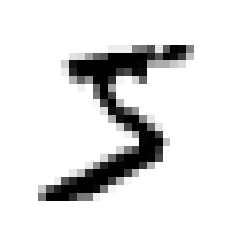

In [5]:
plt.imshow(img.squeeze(), cmap='gist_yarg')
plt.axis('off')

### DataLoader

In [6]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [7]:
for img, label in train_loader:
    break
img.shape

torch.Size([100, 1, 28, 28])

### Create the Network

In [8]:
in_features = 784
out_features = 10

- nn.Sequential() creates an ordered dict where each layer is placed sequentially.
- Modules are stored in self._modules (ordered dict)
- When an instance of nn.Sequential() is run, "input" enters the first module and the result is passed onto the next module until the final result is returned.

In [ ]:
# class Sequential(Module):
#     ...
#     def forward(self, input):
#         for module in self:
#             input = module(input)
#         return input

In [ ]:
# class Module:
#     ...
#     def __init__(self):
#         ...
#         self.training = True
#         self._parameters = OrderedDict()
#         self._buffers = OrderedDict()
#         self._non_persistent_buffers_set = set()
#         self._backward_hooks = OrderedDict()
#         self._is_full_backward_hook = None
#         self._forward_hooks = OrderedDict()
#         self._forward_pre_hooks = OrderedDict()
#         self._state_dict_hooks = OrderedDict()
#         self._load_state_dict_pre_hooks = OrderedDict()
#         self._modules = OrderedDict()
#         ...

그냥 ordered dict 사용하면 되지 않나? 굳이 Sequential 컨테이너에 넣는 이유?
- "Sequential" 자체에 transformation을 할 경우, 컨테이너에 포함된 모든 모듈에 한꺼번에 적용시킬 수 있다는 이점이 있기 때문 (custom random initialization 등)

In [15]:
# ANN, 2 hidden layers
mnist_classifier = nn.Sequential(
    nn.Linear(in_features, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, out_features)
)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mnist_classifier.parameters(), lr=1e-3)

In [14]:
display(mnist_classifier) # nn.Sequential instance
display(len(mnist_classifier))
display(mnist_classifier[0])
mnist_classifier[0] = nn.Linear(in_features, 140) # __setitem__
mnist_classifier # instance를 생성하는 단계에서는 feature 개수 mismatch에 따른 오류 발생 x

Sequential(
  (0): Linear(in_features=784, out_features=140, bias=True)
  (1): ReLU()
  (2): Linear(in_features=120, out_features=84, bias=True)
  (3): ReLU()
  (4): Linear(in_features=84, out_features=10, bias=True)
)

5

Linear(in_features=784, out_features=140, bias=True)

Sequential(
  (0): Linear(in_features=784, out_features=140, bias=True)
  (1): ReLU()
  (2): Linear(in_features=120, out_features=84, bias=True)
  (3): ReLU()
  (4): Linear(in_features=84, out_features=10, bias=True)
)

### nn.Linear
- in_features, out_features를 파라미터로 받아서
- self.weight -> (out_features, in_features) 크기에 해당하는 empty tensor를 저장
- self.bias -> out_features 크기에 해당하는 empty bias vector를 저장
- init.kaiming_uniform_()으로 weight random initialization
- forward()하면 F.linear() -> torch._C._nn.linear(input, weight, bias) -> 이 코드는 CPP로 작성되어 있는 것 같지만 matmul을 통해 y = xA^T + b 수행하는 듯함

In [ ]:
# class Linear(Module):
#     ...
#     def __init__(self, in_features: int, out_features: int, bias: bool = True,
#                  device=None, dtype=None) -> None:
#         factory_kwargs = {'device': device, 'dtype': dtype}
#         super(Linear, self).__init__()
#         self.in_features = in_features
#         self.out_features = out_features
#         self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
#         if bias:
#             self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
#         else:
#             self.register_parameter('bias', None)
#         self.reset_parameters()

#     def reset_parameters(self) -> None:
#         init.kaiming_uniform_(self.weight, a=math.sqrt(5))
#         if self.bias is not None:
#             fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
#             bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
#             init.uniform_(self.bias, -bound, bound)

#     def forward(self, input: Tensor) -> Tensor:
#         return F.linear(input, self.weight, self.bias)

torch에서는 기본적으로 He initialization을 사용하지만, 아래 방법과 같이 random initialization 방법을 지정해서 manual하게 적용할 수도 있다고 한다(https://jh-bk.tistory.com/10). 이래서 일종의 transformation을 할 때 Sequential 컨테이너로 모듈들을 묶는 게 편하다는 것 같다.

In [ ]:
# def weight_init_xavier_uniform(submodule):
#     if isinstance(submodule, torch.nn.Conv2d):
#         torch.nn.init.xavier_uniform_(submodule.weight)
#         submodule.bias.data.fill_(0.01)
#     elif isinstance(submodule, torch.nn.BatchNorm2d):
#         submodule.weight.data.fill_(1.0)
#         submodule.bias.data.zero_()

# SequentialModel = torch.nn.Sequential(
#         torch.nn.Conv2d(1, 1, 2),
#         torch.nn.Conv2d(1, 1, 2),
#         torch.nn.BatchNorm2d(1),
#     )
# SequentialModel.apply(weight_init_xavier_uniform)

### Module 클래스의 parameters 확인

In [ ]:
# class Module:
#     ...
#     def parameters(self, recurse: bool = True) -> Iterator[Parameter]:
#         r"""Returns an iterator over module parameters.

#         This is typically passed to an optimizer.

#         Args:
#             recurse (bool): if True, then yields parameters of this module
#                 and all submodules. Otherwise, yields only parameters that
#                 are direct members of this module.

#         Yields:
#             Parameter: module parameter

#         Example::

#             >>> for param in model.parameters():
#             >>>     print(type(param), param.size())
#             <class 'torch.Tensor'> (20L,)
#             <class 'torch.Tensor'> (20L, 1L, 5L, 5L)

#         """
#         for name, param in self.named_parameters(recurse=recurse):
#             yield param

In [26]:
for name, p in mnist_classifier.named_parameters():
    print((name, p.numel()), p, sep='\n\n')

('0.weight', 94080)

Parameter containing:
tensor([[-0.0125, -0.0285,  0.0278,  ..., -0.0154, -0.0293,  0.0282],
        [ 0.0090,  0.0116,  0.0255,  ...,  0.0319,  0.0077, -0.0292],
        [-0.0124, -0.0237, -0.0121,  ..., -0.0295, -0.0242,  0.0223],
        ...,
        [ 0.0045,  0.0141,  0.0109,  ..., -0.0077, -0.0114,  0.0137],
        [-0.0030, -0.0235,  0.0004,  ...,  0.0008, -0.0304,  0.0302],
        [ 0.0053, -0.0053,  0.0225,  ...,  0.0226, -0.0131, -0.0339]],
       requires_grad=True)
('0.bias', 120)

Parameter containing:
tensor([-0.0299,  0.0242, -0.0191, -0.0121, -0.0072,  0.0087,  0.0049, -0.0025,
        -0.0101, -0.0143,  0.0311, -0.0022,  0.0209, -0.0030,  0.0201, -0.0316,
         0.0111, -0.0087, -0.0352, -0.0234, -0.0278, -0.0224,  0.0101, -0.0181,
         0.0245,  0.0013, -0.0181,  0.0061, -0.0060,  0.0081, -0.0206,  0.0170,
        -0.0342,  0.0214,  0.0192,  0.0228, -0.0294, -0.0269,  0.0110, -0.0303,
        -0.0234, -0.0221,  0.0305,  0.0255, -0.0203,  0.0

In [28]:
params = [p.numel() for p in mnist_classifier.parameters() if p.requires_grad]
np.sum(params)

105214

### Training and Evaluation

In [29]:
sample_batch, sample_labels = iter(train_loader).next()
sample_batch.shape

torch.Size([100, 1, 28, 28])

In [30]:
print(sample_batch.flatten(1).shape)
print(sample_batch.reshape(100, -1).shape)
print(sample_batch.view(100, -1).shape)

torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])


reshape과 view 메소드의 차이
- 기본적으로 동일하지만, tensor 상태가 contiguous(파이토치 메모리 내에서의 자료형 저장 상태; axis 순서대로 자료가 저장된 상태라면 contiguous하고, 자료 저장 순서가 transpose 등으로 인해 원래 방향과 어긋난 경우라면 contiguous하지 않다)하지 않을 경우 view 메소드는 사용하지 못한다. (https://jimmy-ai.tistory.com/122)

In [31]:
y_sample_pred = mnist_classifier(sample_batch.view(100, -1))
# y_sample_pred = F.log_softmax(y_sample_pred, dim=1)
y_sample_pred.shape

torch.Size([100, 10])

nn.CrossEntropyLoss()를 사용하면서 nn.Sequential() 마지막 layer에 nn.Softmax()를 넣어주지 않았는데,  
train 과정에서 prediction 구할 때에는 logit 값에 추가적으로 softmax()를 씌워줘서 argmax를 해야하나?
- softmax는 x가 증가함에 따라 y가 증가하는 함수이므로 logit 값으로 argmax를 하든, softmax(logit) 값으로 argmax를 하든 그 결과는 달라지지 않는다.
- 따라서 train에서 acc를 구할 떄에도 그냥 logit 값에다가 argmax를 해도 상관없을듯!

In [36]:
val, idx = torch.max(y_sample_pred, dim=1)
idx

tensor([9, 9, 9, 9, 3, 9, 9, 3, 9, 9, 9, 9, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3,
        3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 9, 9, 9, 9, 9, 3, 8, 3, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 9, 9, 3, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 3, 9, 9, 9, 9, 9, 3, 9, 9, 9, 9, 8, 9, 9,
        9, 9, 9, 3])

In [35]:
val, idx = torch.max(F.softmax(y_sample_pred, dim=1), dim=1)
idx

tensor([9, 9, 9, 9, 3, 9, 9, 3, 9, 9, 9, 9, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3,
        3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 9, 9, 9, 9, 9, 3, 8, 3, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 9, 9, 3, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 3, 9, 9, 9, 9, 9, 3, 9, 9, 9, 9, 8, 9, 9,
        9, 9, 9, 3])

In [37]:
class Loss:
    train: list = []
    test: list = []
    
class Accuracy:
    train: list = []
    test: list = []

In [39]:
epochs = 10
for epoch in tqdm(range(epochs)):
    train_corr_cnt = 0
    test_corr_cnt = 0
    
    # train
    for batch_idx, (img, label) in enumerate(train_loader, 1):
        y_pred = mnist_classifier(img.view(100, -1))
        loss = loss_func(y_pred, label) ##### 이 부분 체크 -> nn.CrossEntropyLoss()
        
        _, prediction = torch.max(y_pred, dim=1)
        train_corr_cnt += (prediction == label).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            acc = 100 * (train_corr_cnt / (batch_idx*100))
            print(f"Epoch:{epoch:2d} Batch:{batch_idx:2d} Loss:{loss:4.4f} Accuracy:{acc:4.4f}%")
            
    Loss.train.append(loss)
    accuracy = 100 * (train_corr_cnt / (batch_idx*100))
    Accuracy.train.append(accuracy)
    
    # validation (test)
    with torch.no_grad():
        for batch_idx, (img, label) in enumerate(test_loader, 1):
            y_val = mnist_classifier(img.view(500, -1))
            _, predicted = torch.max(y_val, dim=1)
            test_corr_cnt += (predicted == label).sum()
            
    loss = loss_func(y_val, label)
    Loss.test.append(loss)
    accuracy = 100 * (test_corr_cnt / (batch_idx * 500))
    Accuracy.test.append(accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 Batch:200 Loss:0.1969 Accuracy:95.7750%
Epoch: 0 Batch:400 Loss:0.1378 Accuracy:95.8650%
Epoch: 0 Batch:600 Loss:0.1190 Accuracy:96.0217%


 10%|█         | 1/10 [00:24<03:43, 24.88s/it]

Epoch: 1 Batch:200 Loss:0.0714 Accuracy:96.9550%
Epoch: 1 Batch:400 Loss:0.0520 Accuracy:97.0975%
Epoch: 1 Batch:600 Loss:0.0528 Accuracy:97.0633%


 20%|██        | 2/10 [00:48<03:13, 24.15s/it]

Epoch: 2 Batch:200 Loss:0.0507 Accuracy:97.6850%
Epoch: 2 Batch:400 Loss:0.1454 Accuracy:97.6800%
Epoch: 2 Batch:600 Loss:0.0749 Accuracy:97.6967%


 30%|███       | 3/10 [01:11<02:45, 23.58s/it]

Epoch: 3 Batch:200 Loss:0.0702 Accuracy:98.1400%
Epoch: 3 Batch:400 Loss:0.0353 Accuracy:98.0725%
Epoch: 3 Batch:600 Loss:0.0606 Accuracy:98.0700%


 40%|████      | 4/10 [01:36<02:25, 24.22s/it]

Epoch: 4 Batch:200 Loss:0.0242 Accuracy:98.5600%
Epoch: 4 Batch:400 Loss:0.0451 Accuracy:98.3925%
Epoch: 4 Batch:600 Loss:0.0434 Accuracy:98.4467%


 50%|█████     | 5/10 [01:58<01:57, 23.51s/it]

Epoch: 5 Batch:200 Loss:0.0535 Accuracy:98.6600%
Epoch: 5 Batch:400 Loss:0.0127 Accuracy:98.6775%
Epoch: 5 Batch:600 Loss:0.1138 Accuracy:98.6617%


 60%|██████    | 6/10 [02:21<01:33, 23.38s/it]

Epoch: 6 Batch:200 Loss:0.0464 Accuracy:99.0550%
Epoch: 6 Batch:400 Loss:0.0277 Accuracy:98.9750%
Epoch: 6 Batch:600 Loss:0.0988 Accuracy:98.9417%


 70%|███████   | 7/10 [02:57<01:22, 27.47s/it]

Epoch: 7 Batch:200 Loss:0.0656 Accuracy:99.2950%
Epoch: 7 Batch:400 Loss:0.0287 Accuracy:99.1475%
Epoch: 7 Batch:600 Loss:0.0711 Accuracy:99.1267%


 80%|████████  | 8/10 [03:35<01:01, 30.67s/it]

Epoch: 8 Batch:200 Loss:0.0344 Accuracy:99.3350%
Epoch: 8 Batch:400 Loss:0.0594 Accuracy:99.2650%
Epoch: 8 Batch:600 Loss:0.0287 Accuracy:99.2250%


 90%|█████████ | 9/10 [04:05<00:30, 30.38s/it]

Epoch: 9 Batch:200 Loss:0.0093 Accuracy:99.4500%
Epoch: 9 Batch:400 Loss:0.0047 Accuracy:99.3575%
Epoch: 9 Batch:600 Loss:0.0138 Accuracy:99.3417%


100%|██████████| 10/10 [04:31<00:00, 27.19s/it]


In [44]:
Loss.train = [i.item() for i in Loss.train]
Loss.test = [i.item() for i in Loss.test]
Accuracy.train = [i.item() for i in Accuracy.train]
Accuracy.test = [i.item() for i in Accuracy.test]

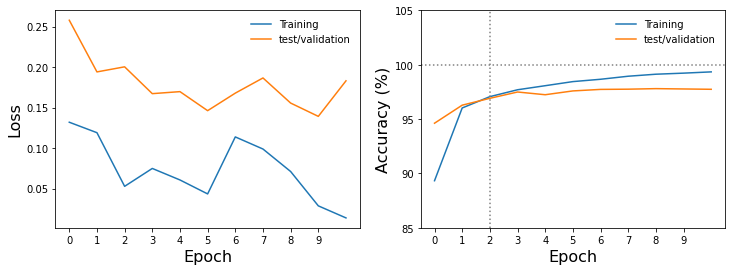

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(Loss.train, label = 'Training')
ax[0].plot(Loss.test, label='test/validation')
ax[0].set_ylabel('Loss', fontsize=16)


ax[1].plot(Accuracy.train, label = 'Training')
ax[1].plot(Accuracy.test, label='test/validation')
ax[1].set_yticks(range(85,110,5))
ax[1].axvline(x=2, color='gray', linestyle=':')
ax[1].axhline(y=100, color='gray', linestyle=':')
ax[1].set_ylabel('Accuracy (%)', fontsize=16)

for myax in ax:
    myax.set_xlabel('Epoch', fontsize=16)
    myax.set_xticks(range(epochs))
    myax.legend(frameon=False)

In [49]:
test_loader = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    
    for X, y_label in test_loader:
        y_val = mnist_classifier(X.view(X.shape[0], -1)) # flatten
        _, predicted= torch.max(y_val, dim=1)
        correct += (predicted == y_label).sum()
        
print(f"Test Accuracy: {correct.item()*100/len(test_data):2.4f}%")

Test Accuracy: 97.7400%


In [50]:
from sklearn.metrics import confusion_matrix  # for evaluating results
confusion_array = confusion_matrix(y_true = y_label,y_pred = predicted)
confusion_array

array([[ 967,    0,    0,    2,    0,    4,    1,    2,    3,    1],
       [   0, 1127,    3,    0,    0,    0,    1,    0,    4,    0],
       [   4,    3, 1006,    2,    2,    0,    1,    5,    9,    0],
       [   0,    1,    3,  986,    0,    5,    0,    4,    5,    6],
       [   0,    0,    4,    0,  964,    1,    3,    2,    2,    6],
       [   2,    0,    0,    8,    1,  876,    1,    0,    3,    1],
       [   2,    3,    0,    1,    7,    5,  930,    3,    7,    0],
       [   1,    6,    7,    0,    0,    0,    0, 1005,    4,    5],
       [   5,    0,    2,    3,    2,    7,    1,    4,  950,    0],
       [   3,    2,    0,    5,   15,    6,    0,    9,    6,  963]],
      dtype=int64)

<AxesSubplot:>

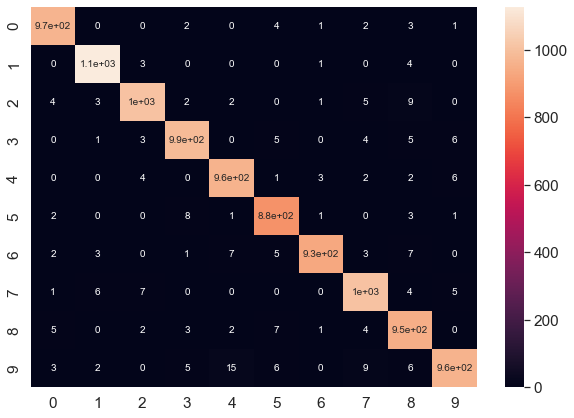

In [51]:
import pandas as pd
import seaborn as sn
df_cm = pd.DataFrame(confusion_array, range(10), range(10))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size